# DDoS attacks detection and characterization

First, we need to import the necessary libraries.

In [176]:
# import needed python libraries

%matplotlib inline

import pandas as pd
import seaborn as sns
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
import warnings

## Supervised learning - classification
Now we load the transformed dataset from the csv we created in the previous jupyter notebook.

In [177]:
# Load the dataset
df = pd.read_csv("preprocessed_dataset.csv", header=0, index_col=0, engine='python')

df


,Source IP,Source Port,Destination Port,Total Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,Flow Bytes/s,Fwd IAT Min,...,Init_Win_bytes_forward,Init_Win_bytes_backward,act_data_pkt_fwd,Active Max,Active Min,Idle Std,Idle Min,Inbound,protocol_0,label
0,2886729733,634,60495,97,440.0,0.000000,0.0,0.0,1.502024e+06,1.0,...,-1,-1,96,0.0,0.0,0.0,0.0,1,0,ddos_dns
1,3232248321,634,60495,2,440.0,0.000000,0.0,0.0,4.400000e+08,2.0,...,-1,-1,1,0.0,0.0,0.0,0.0,0,0,ddos_dns
2,2886729733,634,46391,200,440.0,0.000000,0.0,0.0,1.812602e+06,1.0,...,-1,-1,199,0.0,0.0,0.0,0.0,1,0,ddos_dns
3,2886729733,634,11894,200,440.0,0.000000,0.0,0.0,1.820552e+06,1.0,...,-1,-1,199,0.0,0.0,0.0,0.0,1,0,ddos_dns
4,2886729733,634,27878,200,440.0,0.000000,0.0,0.0,2.747767e+06,0.0,...,-1,-1,199,0.0,0.0,0.0,0.0,1,0,ddos_dns
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65995,2886729733,38625,63051,2,375.0,0.000000,0.0,0.0,7.500000e+08,1.0,...,-1,-1,1,0.0,0.0,0.0,0.0,1,0,ddos_udp_lag
65996,2886729733,58632,18963,6,393.0,35.088460,0.0,0.0,9.838012e+03,1.0,...,-1,-1,5,0.0,0.0,0.0,0.0,1,0,ddos_udp_lag
65997,2886729733,46104,64704,2,375.0,0.000000,0.0,0.0,7.500000e+08,1.0,...,-1,-1,1,0.0,0.0,0.0,0.0,1,0,ddos_udp_lag
65998,2886729733,60686,10440,4,389.0,34.063666,0.0,0.0,1.319847e+04,1.0,...,-1,-1,3,0.0,0.0,0.0,0.0,1,0,ddos_udp_lag


We decided to use the following algorithms to perform supervised learning:
- K-NN
- multi-class Logistic Regression (one-vs-rest scheme)
- Random Forest

Then, we proceed analyzing their performances using the default parameters.

In [178]:
X_df = df.drop(columns='label').to_numpy()
y_df = df[['label']].to_numpy()

# run stratified training-test splitting using train_test_split
X_train_val, X_test, y_train_val, y_test = train_test_split(X_df, y_df, stratify=y_df, train_size=0.7, random_state=15)
y_train_val, y_test = np.ravel(y_train_val), np.ravel(y_test)

In [179]:
# k-NN
knn_clf = KNeighborsClassifier(n_neighbors=5)
knn_clf.fit(X_train_val, y_train_val)
y_train_pred_knn = knn_clf.predict(X_train_val)
y_test_pred_knn = knn_clf.predict(X_test)

# LR
lr_clf = LogisticRegression(max_iter=100)
lr_clf.fit(X_train_val, y_train_val)
y_train_pred_lr = lr_clf.predict(X_train_val)
y_test_pred_lr = lr_clf.predict(X_test)

# RF
rf_clf = RandomForestClassifier(n_estimators=100)
rf_clf.fit(X_train_val, y_train_val)
y_train_pred_rf = rf_clf.predict(X_train_val)
y_test_pred_rf = rf_clf.predict(X_test)

# SVM
svc_clf = LinearSVC()
svc_clf.fit(X_train_val, y_train_val)
y_train_pred_svc = svc_clf.predict(X_train_val)
y_test_pred_svc = svc_clf.predict(X_test)

# GaussianNB
gaussianNB_clf = GaussianNB()
gaussianNB_clf.fit(X_train_val, y_train_val)
y_train_pred_gaussianNB = gaussianNB_clf.predict(X_train_val)
y_test_pred_gaussianNB = gaussianNB_clf.predict(X_test)


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [180]:
# k-NN
print("k-NN")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_knn))
print('Test set')
print(classification_report(y_test, y_test_pred_knn))

k-NN
Training set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      3961
    ddos_dns       0.97      0.89      0.92      3758
   ddos_ldap       0.66      0.86      0.75      4149
  ddos_mssql       0.74      0.56      0.64      4138
ddos_netbios       0.95      0.97      0.96      4081
    ddos_ntp       0.89      0.97      0.93       690
   ddos_snmp       0.99      0.99      0.99      4189
   ddos_ssdp       0.82      0.79      0.81      4179
    ddos_syn       0.98      0.98      0.98      3836
   ddos_tftp       0.98      0.98      0.98      3683
    ddos_udp       0.72      0.72      0.72      4113
ddos_udp_lag       0.72      0.72      0.72      4190

    accuracy                           0.86     44967
   macro avg       0.87      0.87      0.87     44967
weighted avg       0.86      0.86      0.86     44967

Test set
              precision    recall  f1-score   support

      benign       0.99      1.00      0.99      16

In [181]:
# LR
print("LOGISTIC REGRESSION")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_lr, zero_division=0))
print('Test set')
print(classification_report(y_test, y_test_pred_lr, zero_division=0))

LOGISTIC REGRESSION
Training set
              precision    recall  f1-score   support

      benign       0.22      0.94      0.35      3961
    ddos_dns       0.02      0.01      0.02      3758
   ddos_ldap       0.46      0.67      0.54      4149
  ddos_mssql       0.12      0.00      0.01      4138
ddos_netbios       0.36      0.61      0.45      4081
    ddos_ntp       0.00      0.00      0.00       690
   ddos_snmp       0.76      0.69      0.72      4189
   ddos_ssdp       0.44      0.59      0.50      4179
    ddos_syn       0.66      0.34      0.45      3836
   ddos_tftp       0.00      0.00      0.00      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.04      0.01      0.01      4190

    accuracy                           0.35     44967
   macro avg       0.26      0.32      0.26     44967
weighted avg       0.28      0.35      0.28     44967

Test set
              precision    recall  f1-score   support

      benign       0.22      0.94   

In [182]:
# RF
print("RANDOM FOREST")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_rf))
print('Test set')
print(classification_report(y_test, y_test_pred_rf))

RANDOM FOREST
Training set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      3961
    ddos_dns       1.00      1.00      1.00      3758
   ddos_ldap       1.00      1.00      1.00      4149
  ddos_mssql       1.00      1.00      1.00      4138
ddos_netbios       1.00      1.00      1.00      4081
    ddos_ntp       1.00      1.00      1.00       690
   ddos_snmp       1.00      1.00      1.00      4189
   ddos_ssdp       1.00      1.00      1.00      4179
    ddos_syn       1.00      1.00      1.00      3836
   ddos_tftp       1.00      1.00      1.00      3683
    ddos_udp       1.00      1.00      1.00      4113
ddos_udp_lag       1.00      1.00      1.00      4190

    accuracy                           1.00     44967
   macro avg       1.00      1.00      1.00     44967
weighted avg       1.00      1.00      1.00     44967

Test set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.0

In [183]:
# SVM
print("SUPPORT VECTOR MACHINES (SVM)")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_svc, zero_division=0))
print('Test set')
print(classification_report(y_test, y_test_pred_svc, zero_division=0))

SUPPORT VECTOR MACHINES (SVM)
Training set
              precision    recall  f1-score   support

      benign       0.25      0.88      0.39      3961
    ddos_dns       0.10      0.03      0.05      3758
   ddos_ldap       0.35      0.92      0.50      4149
  ddos_mssql       0.05      0.00      0.01      4138
ddos_netbios       0.98      0.37      0.53      4081
    ddos_ntp       0.56      0.01      0.01       690
   ddos_snmp       0.39      0.86      0.54      4189
   ddos_ssdp       0.83      0.24      0.37      4179
    ddos_syn       0.97      0.40      0.56      3836
   ddos_tftp       0.60      0.78      0.68      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.00      0.00      0.00      4190

    accuracy                           0.40     44967
   macro avg       0.42      0.37      0.30     44967
weighted avg       0.41      0.40      0.32     44967

Test set
              precision    recall  f1-score   support

      benign       0.25   

In [184]:
# Naive Bayes Classifier
print("NAIVE BAYES CLASSIFIER")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_gaussianNB, zero_division=0))
print('Test set')
print(classification_report(y_test, y_test_pred_gaussianNB, zero_division=0))

NAIVE BAYES CLASSIFIER
Training set
              precision    recall  f1-score   support

      benign       0.96      0.23      0.37      3961
    ddos_dns       0.40      0.04      0.07      3758
   ddos_ldap       0.45      0.68      0.54      4149
  ddos_mssql       0.00      0.00      0.00      4138
ddos_netbios       1.00      0.24      0.39      4081
    ddos_ntp       0.08      0.32      0.12       690
   ddos_snmp       0.87      0.87      0.87      4189
   ddos_ssdp       0.56      0.84      0.67      4179
    ddos_syn       0.65      0.41      0.50      3836
   ddos_tftp       0.33      0.00      0.00      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.20      0.98      0.33      4190

    accuracy                           0.40     44967
   macro avg       0.46      0.38      0.32     44967
weighted avg       0.48      0.40      0.34     44967

Test set
              precision    recall  f1-score   support

      benign       0.96      0.22

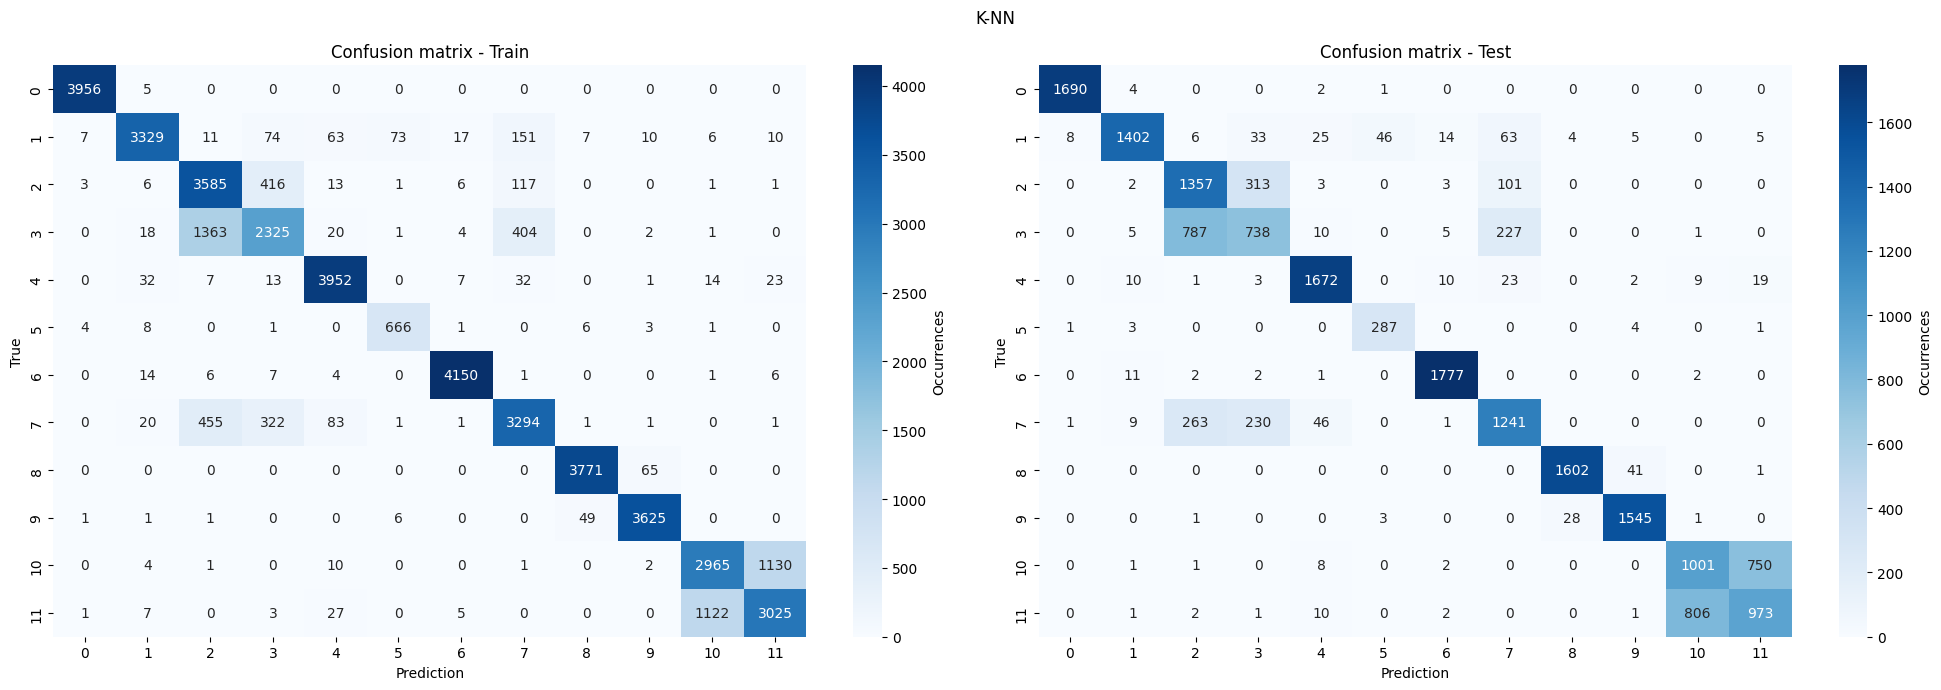

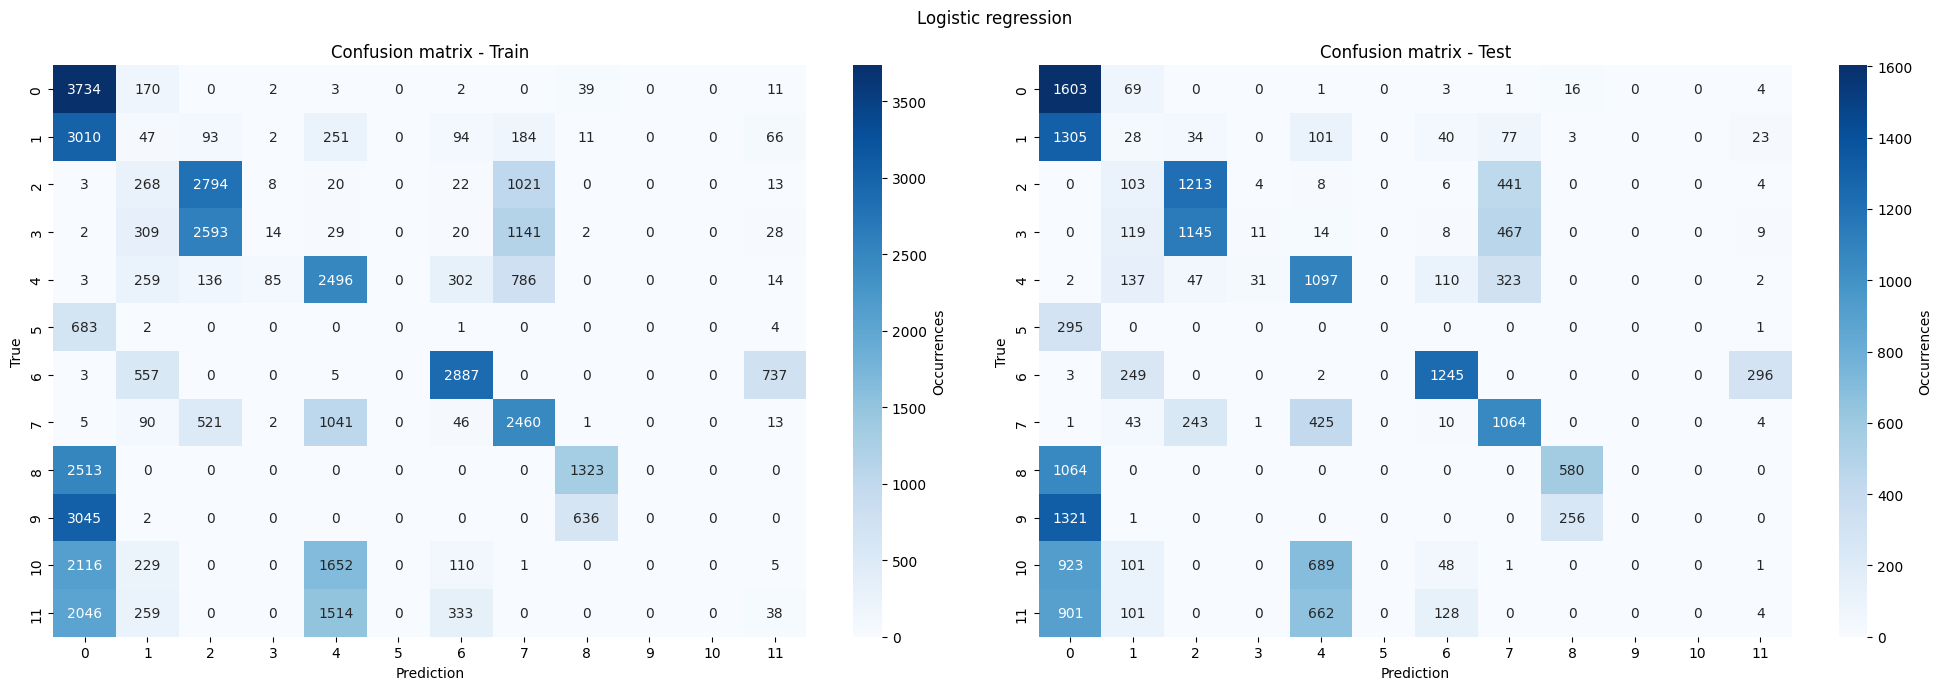

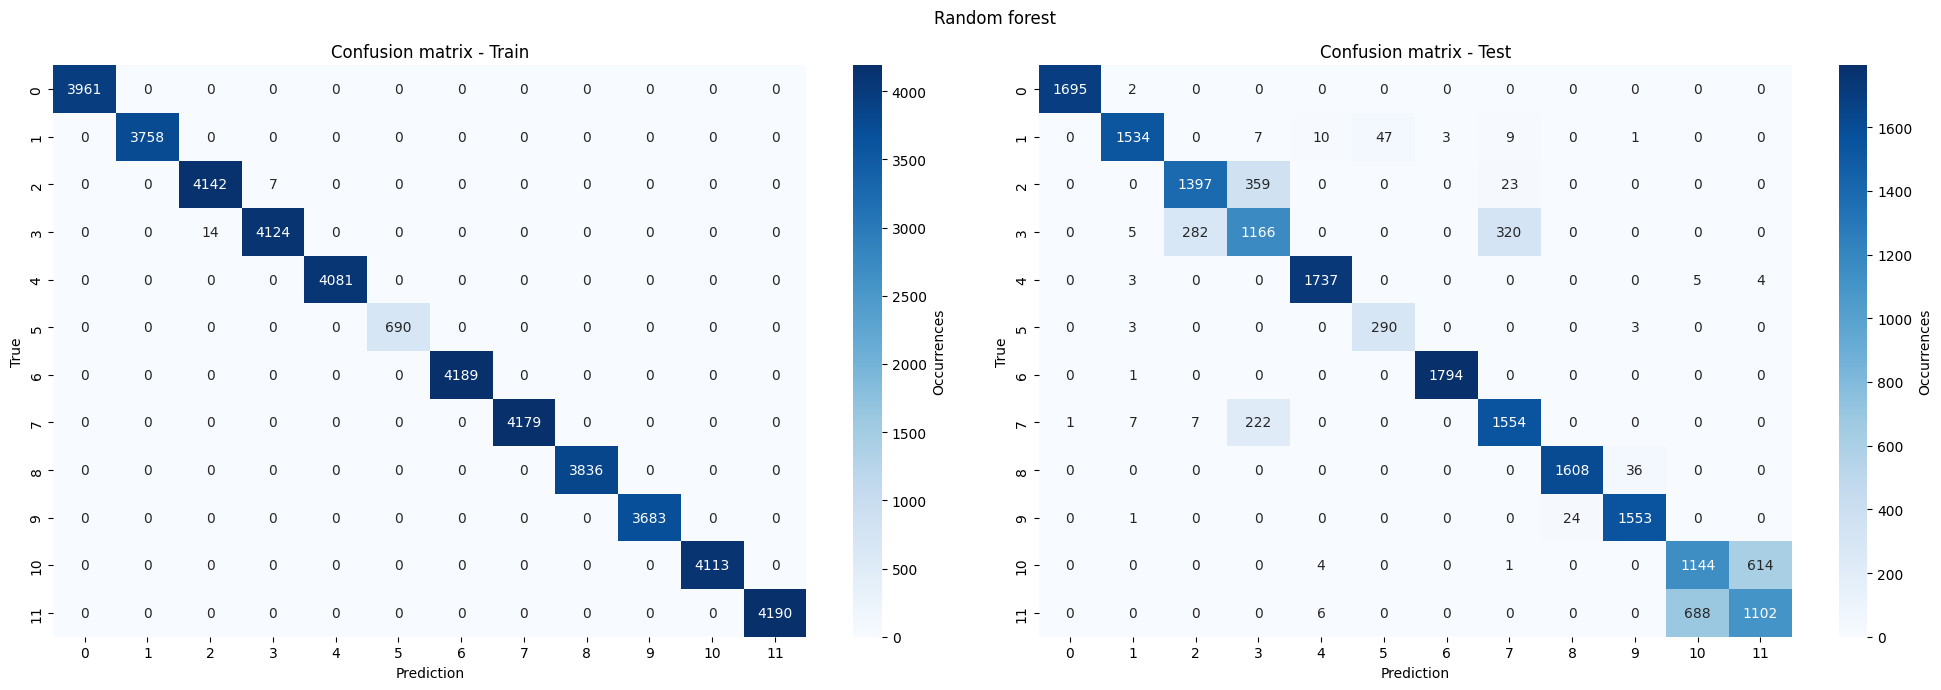

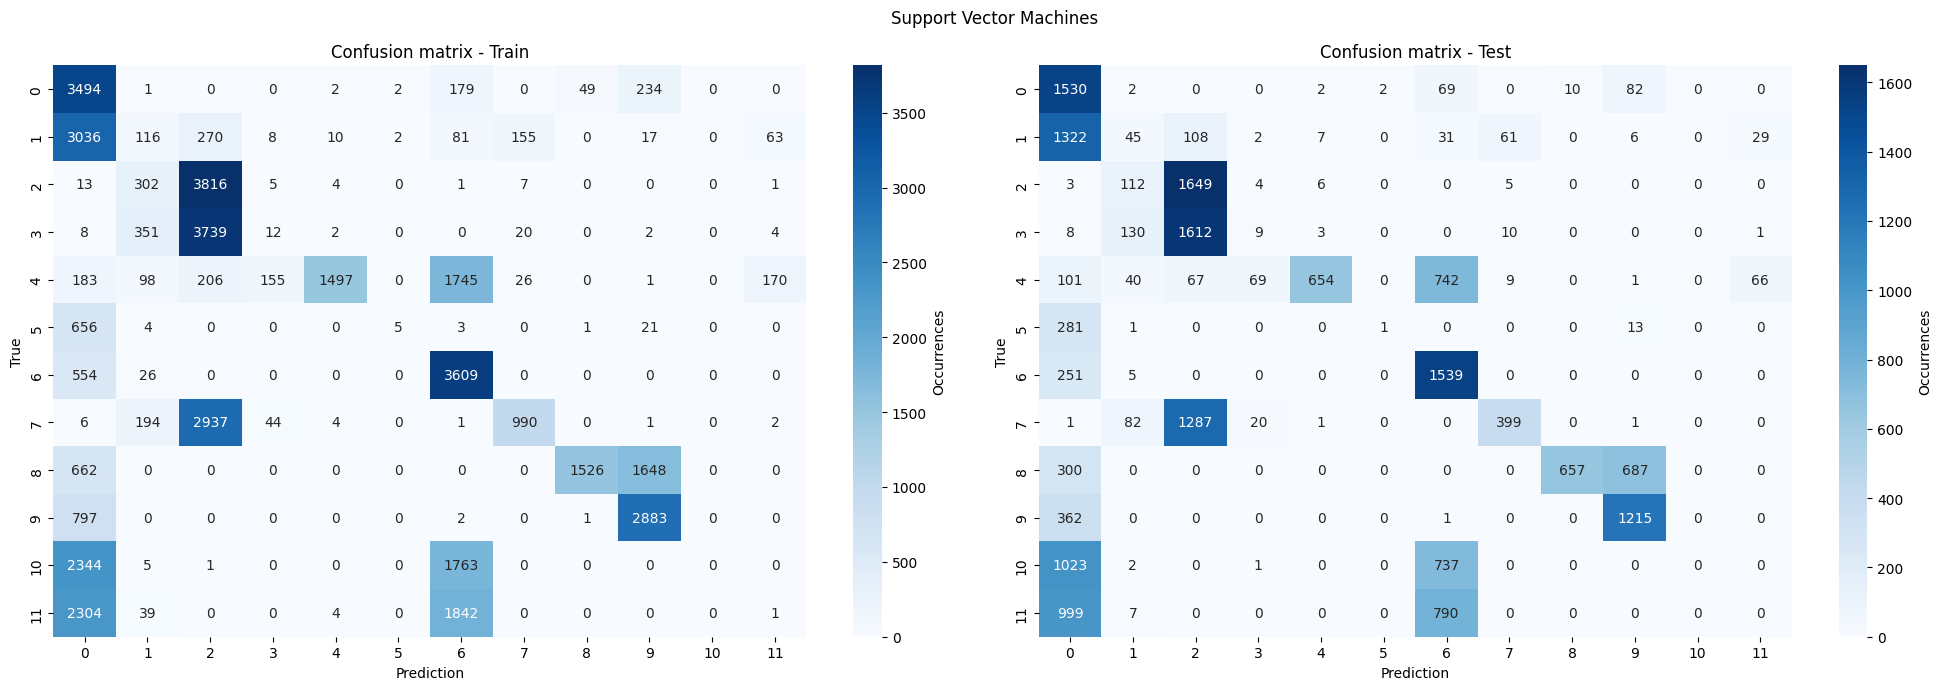

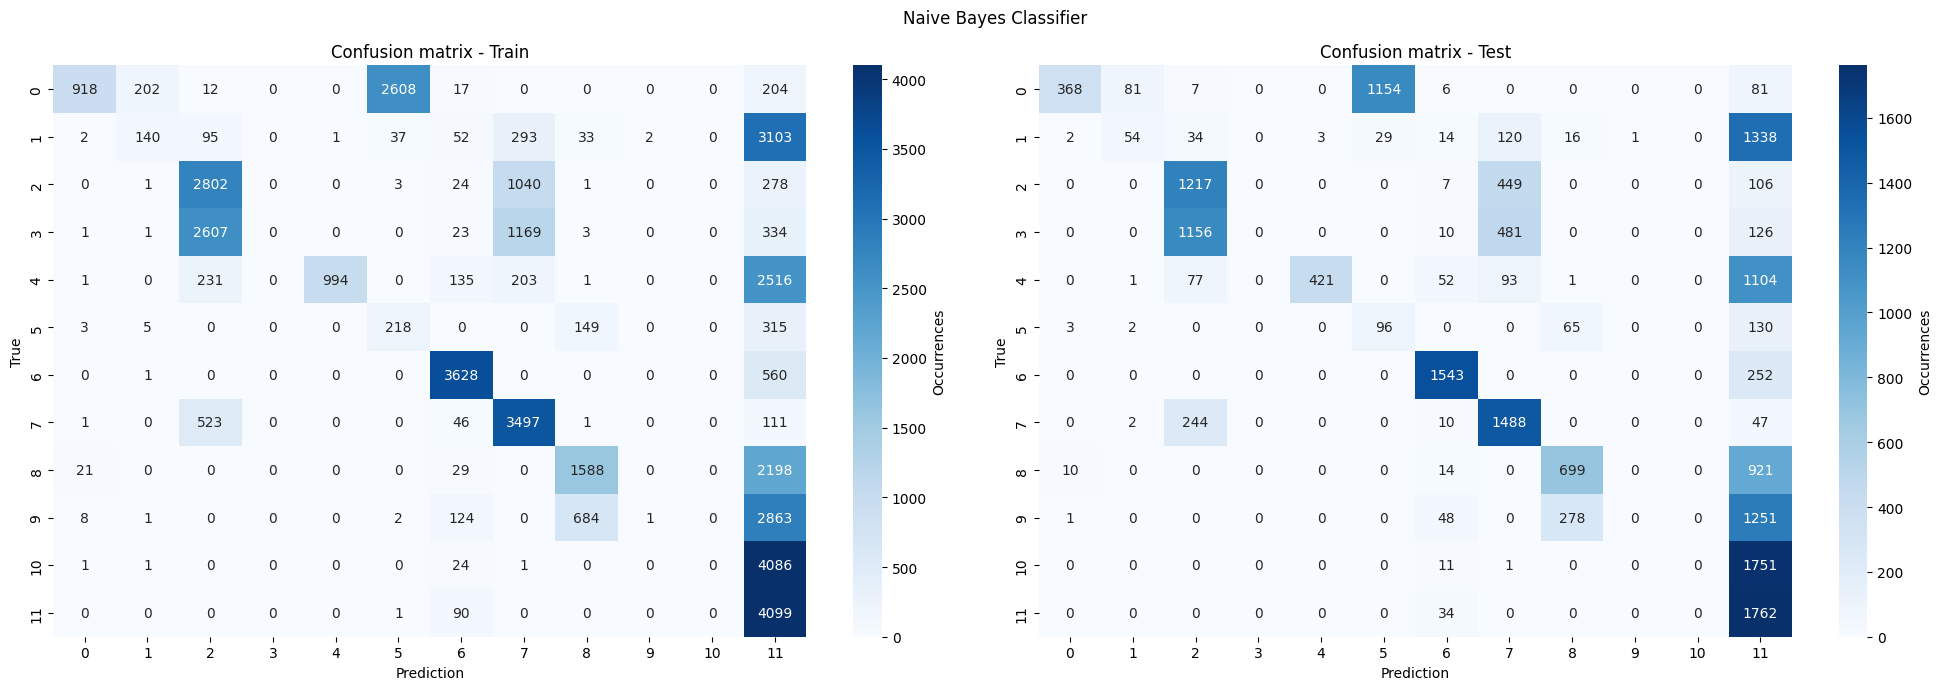

In [185]:
# k-NN
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

confusion_train = confusion_matrix(y_train_val, y_train_pred_knn)
sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('True')
ax1.set_title('Confusion matrix - Train')

confusion_test = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
ax2.set_xlabel('Prediction')
ax2.set_ylabel('True')
ax2.set_title('Confusion matrix - Test')
fig.suptitle("K-NN")

plt.tight_layout()
plt.show()

# LR
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

confusion_train = confusion_matrix(y_train_val, y_train_pred_lr)
sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('True')
ax1.set_title('Confusion matrix - Train')

confusion_test = confusion_matrix(y_test, y_test_pred_lr)
sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
ax2.set_xlabel('Prediction')
ax2.set_ylabel('True')
ax2.set_title('Confusion matrix - Test')
fig.suptitle("Logistic regression")

plt.tight_layout()
plt.show()

# RF
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

confusion_train = confusion_matrix(y_train_val, y_train_pred_rf)
sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('True')
ax1.set_title('Confusion matrix - Train')

confusion_test = confusion_matrix(y_test, y_test_pred_rf)
sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
ax2.set_xlabel('Prediction')
ax2.set_ylabel('True')
ax2.set_title('Confusion matrix - Test')
fig.suptitle("Random forest")

plt.tight_layout()
plt.show()

# SVM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

confusion_train = confusion_matrix(y_train_val, y_train_pred_svc)
sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('True')
ax1.set_title('Confusion matrix - Train')

confusion_test = confusion_matrix(y_test, y_test_pred_svc)
sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
ax2.set_xlabel('Prediction')
ax2.set_ylabel('True')
ax2.set_title('Confusion matrix - Test')
fig.suptitle("Support Vector Machines")

plt.tight_layout()
plt.show()

# Naive Bayes Classifier
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

confusion_train = confusion_matrix(y_train_val, y_train_pred_gaussianNB)
sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('True')
ax1.set_title('Confusion matrix - Train')

confusion_test = confusion_matrix(y_test, y_test_pred_gaussianNB)
sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
ax2.set_xlabel('Prediction')
ax2.set_ylabel('True')
ax2.set_title('Confusion matrix - Test')
fig.suptitle("Naive Bayes Classifier")

plt.tight_layout()
plt.show()

We noticed that:
- K-NN confuses classes ddos_ldap and ddos_mssql (2 and 3), ddos_syn and ddos_tftp (8 and 9), ddos_udp and ddos_udp_lag (10 and 11); 
- LR miscassifies the samples of the class ddos_mssql (very poor performances of trainig and test set), tends to classify as ddos_tftp ddos_syn samples (but not viceversa), it confuses ddos_udp and ddos_udp_lag (10 and 11)
- RF confuses classes ddos_ldap and ddos_mssql (similar to k-NN), tends to classify as ddos_tftp ddos_syn samples (but not viceversa as LR), ddos_udp and ddos_udp_lag (but it tends to misclassify ddos_udp as ddos_udp_lag less then the other models); 
- all three models tends to assign samples of classes ddos_dns, ddos_ldap and ddos_mssql (1-3) to class ddos_ssdp (7), while viceversa is less common.
- the last two models (SVC and Naive Bayes) have poorer performance than Random Forest and k-NN.

It clearly stands out that Random Forest and k-NN models are the best in this initial analysis.

## Hyper-parameter tuning
Now we perform hyper-parameter tuning for the three algorithms we have decided to use.

### KNN - hyper-parameter tuning

In [186]:
import time
# convert the labels in numerical form (needed by the brute force algorithm)
label_encoder = LabelEncoder()
y_np = label_encoder.fit_transform(y_train_val)

#K-NN

# iterate over all possible combinations
best_combination_knn = [0,1,2,3]
acc_max_knn = 0
idx = -1
idx_best_knn = idx
info_accuracy_train_knn = []
info_accuracy_val_knn = []

for n_neighbors in [5, 6, 7, 8, 9]:
    for weights in ['uniform', 'distance']:
        for p in [1, 2]:
            # we do not obtimize 'auto', since it simply chooses the best one among the previous
            for algorithm in ['ball_tree', 'kd_tree', 'brute']:
                print(f"Starting: {n_neighbors} {weights} {p} {algorithm}")
                start = time.time()
                idx += 1

                random_states = set()
                while len(random_states) < 5:
                    n = random.randint(0,1000000)
                    random_states.add(n)

                accuracies_train_tmp = []
                accuracies_val_tmp = []

                # iterate over all random states with same training size to derive the 5 different performance
                for random_state in random_states:
                    # further split into training and validation

                    X_train, X_val, y_train, y_val = train_test_split(
                        X_train_val, y_np,
                        stratify = y_np,
                        train_size = 0.5/0.7,
                        random_state = random_state
                    )


                    # initialize and fit a model per combination of parameters
                    knn_tmp = KNeighborsClassifier(
                        n_neighbors = n_neighbors,
                        weights = weights,
                        p = p,
                        algorithm = algorithm
                    )

                    knn_tmp.fit(X_train, y_train)
                    accuracies_train_tmp.append(accuracy_score(y_train, knn_tmp.predict(X_train)))
                    accuracies_val_tmp.append(accuracy_score(y_val, knn_tmp.predict(X_val)))


                # calculate the statistics to generate overall performance
                accuracies_tmp = np.array(accuracies_train_tmp)
                mean_acc_train = accuracies_tmp.mean()
                min_acc_train = accuracies_tmp.min()
                max_acc_train = accuracies_tmp.max()
                info_accuracy_train_knn.append((mean_acc_train, min_acc_train, max_acc_train))

                accuracies_tmp = np.array(accuracies_val_tmp)
                mean_acc_val = accuracies_tmp.mean()
                min_acc_val = accuracies_tmp.min()
                max_acc_val = accuracies_tmp.max()
                info_accuracy_val_knn.append((mean_acc_val, min_acc_val, max_acc_val))

                if mean_acc_val >= acc_max_knn:
                    idx_best_knn = idx
                    acc_max_knn = mean_acc_val
                    best_combination_knn[0] = n_neighbors
                    best_combination_knn[1] = weights
                    best_combination_knn[2] = p
                    best_combination_knn[3] = algorithm
                print(f"Finished: {n_neighbors} {weights} {p} {algorithm} - {time.time() - start:.2f}s - acc: {mean_acc_train:.4f}/{mean_acc_val:.4f}")


print(
    f'\nBest values: {idx_best_knn} '
    f'n_neighbors: {best_combination_knn[0]}, '
    f'weights: {best_combination_knn[1]}, '
    f'p: {best_combination_knn[2]}, '
    f'algorithm: {best_combination_knn[3]} '
    f'accuracy: {acc_max_knn:.2f}'
)

Starting: 5 uniform 1 ball_tree
Finished: 5 uniform 1 ball_tree - 19.29s - acc: 0.8590/0.7939
Starting: 5 uniform 1 kd_tree
Finished: 5 uniform 1 kd_tree - 15.25s - acc: 0.8586/0.7919
Starting: 5 uniform 1 brute
Finished: 5 uniform 1 brute - 23.85s - acc: 0.8588/0.7942
Starting: 5 uniform 2 ball_tree
Finished: 5 uniform 2 ball_tree - 17.87s - acc: 0.8550/0.7882
Starting: 5 uniform 2 kd_tree
Finished: 5 uniform 2 kd_tree - 14.83s - acc: 0.8567/0.7860
Starting: 5 uniform 2 brute
Finished: 5 uniform 2 brute - 4.48s - acc: 0.8550/0.7884
Starting: 5 distance 1 ball_tree
Finished: 5 distance 1 ball_tree - 11.93s - acc: 0.9997/0.8023
Starting: 5 distance 1 kd_tree
Finished: 5 distance 1 kd_tree - 10.38s - acc: 0.9997/0.8026
Starting: 5 distance 1 brute
Finished: 5 distance 1 brute - 22.44s - acc: 0.9997/0.8013
Starting: 5 distance 2 ball_tree
Finished: 5 distance 2 ball_tree - 14.97s - acc: 0.9997/0.7976
Starting: 5 distance 2 kd_tree
Finished: 5 distance 2 kd_tree - 11.82s - acc: 0.9997/0.79

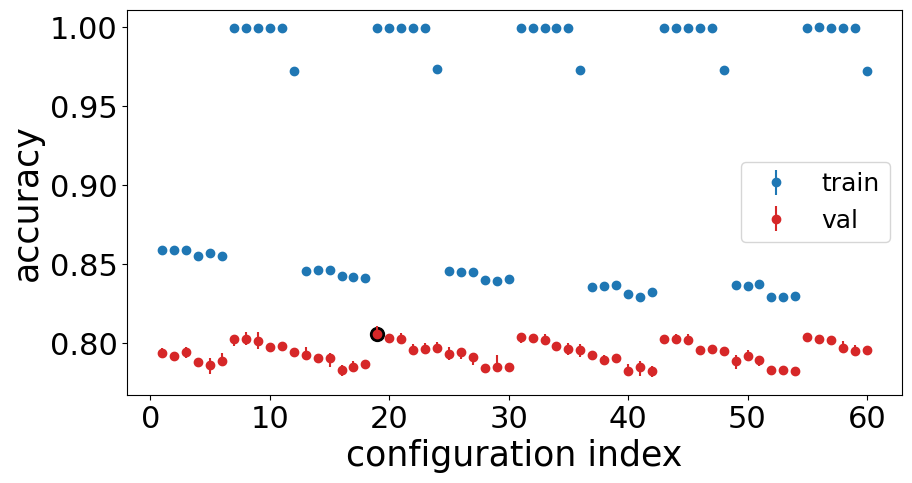

In [192]:
plt.figure(figsize=(10,5))

x = [i for i in range(1, len(info_accuracy_train_knn)+1)]
plt.errorbar(x, [info_accuracy_train_knn[i][0] for i in range(len(info_accuracy_train_knn))],
             yerr=([info_accuracy_train_knn[i][0]-info_accuracy_train_knn[i][1] for i in range(len(info_accuracy_train_knn))],[info_accuracy_train_knn[i][2]-info_accuracy_train_knn[i][0] for i in range(len(info_accuracy_train_knn))]),
             marker='o',
             color='tab:blue', label='train',linestyle='')
plt.errorbar(x, [info_accuracy_val_knn[i][0] for i in range(len(info_accuracy_val_knn))],
             yerr=([info_accuracy_val_knn[i][0]-info_accuracy_val_knn[i][1] for i in range(len(info_accuracy_val_knn))],[info_accuracy_val_knn[i][2]-info_accuracy_val_knn[i][0] for i in range(len(info_accuracy_val_knn))]),
             marker='o',
             color='tab:red', label='val',linestyle='')
#plt.title("Grid search results")
plt.xlabel('configuration index', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.legend(fontsize=18)
plt.tick_params(labelsize=22)

plt.scatter(idx_best_knn+1, acc_max_knn, marker='o', color='black',s=100)

plt.show()

### Logistic Regression - hyper-parameter tuning

In [92]:
# Function to find the value of 'max_iter' that lead to convergence
def fit_until_convergence(X_train, y_train, max_iter_start, step, solver='lbfgs'):
    max_iter = max_iter_start
    count = 0
    while count < 5:
        try:
            with warnings.catch_warnings():
                warnings.filterwarnings("error", category=ConvergenceWarning)
                lr_clf = LogisticRegression(max_iter=max_iter, solver=solver)
                lr_clf.fit(X_train, y_train)
            print(f"Convergence reached with max_iter={max_iter}")
            return lr_clf   # return the trained model
        except ConvergenceWarning:
            print(f"Convergence NOT reached with max_iter={max_iter}, increasing iterations...")
            max_iter += step
            count += 1

# Now we try to observe if the model reaches convergence using the default solver ('lbfgs')

fit_until_convergence(X_train_val, y_train_val, max_iter_start=100000, step=10000, solver='lbfgs')

Convergence NOT reached with max_iter=100000, increasing iterations...
Convergence NOT reached with max_iter=110000, increasing iterations...
Convergence NOT reached with max_iter=120000, increasing iterations...
Convergence NOT reached with max_iter=130000, increasing iterations...
Convergence NOT reached with max_iter=140000, increasing iterations...


### Thanks to the code above we can note that the Logistic Regression model is not able to reach convergence if using the default solver !!!
#### So below we will try a different one.

In [93]:
# Now we try to observe if the model reaches convergence using the 'sag' solver

fit_until_convergence(X_train_val, y_train_val, max_iter_start=5000, step=1000, solver='saga')

Convergence NOT reached with max_iter=5000, increasing iterations...
Convergence NOT reached with max_iter=6000, increasing iterations...
Convergence reached with max_iter=7000


LogisticRegression(max_iter=7000, solver='saga')

We can assert that the logistic regression model starts to converge from max_iterations=10000 onwards when using the '_saga_' solver, so it is advisable to perform hyper-parameter tuning of '_max_iterations_' starting from a value greater than 10000. However, during the training we realized that max_iter=10000 is too low because it would get a very low accuracy score, so we start performing hyper-parameter tuning from a much higher value.

In [ ]:
info_accuracy_train_lr = []
info_accuracy_val_lr = []

for max_iter in range(10000, 25000, 5000) :
    print(f"Starting: {max_iter}")
    start = time.time()

    random_states = set()
    while len(random_states) < 5:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuracies_train_tmp = []
    accuracies_val_tmp = []

    # iterate over all random states with same training size to derive the 10 different performance
    for random_state in random_states:
        # further split into training and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val,
            stratify = y_train_val,
            train_size = 0.5/0.7,
            random_state = random_state
        )

        lr_clf = LogisticRegression(max_iter=max_iter, solver='saga')
        lr_clf.fit(X_train, y_train.ravel())
        accuracies_train_tmp.append(accuracy_score(y_train, lr_clf.predict(X_train)))
        accuracies_val_tmp.append(accuracy_score(y_val, lr_clf.predict(X_val)))

    # calculate the statistics to generate overall performance
    accuracies_tmp = np.array(accuracies_train_tmp)
    mean_acc = accuracies_tmp.mean()
    min_acc = accuracies_tmp.min()
    max_acc = accuracies_tmp.max()
    info_accuracy_train_lr.append((mean_acc, min_acc, max_acc))

    accuracies_tmp = np.array(accuracies_val_tmp)
    mean_acc = accuracies_tmp.mean()
    min_acc = accuracies_tmp.min()
    max_acc = accuracies_tmp.max()
    info_accuracy_val_lr.append((mean_acc, min_acc, max_acc))
    print(f"Finished: {max_iter} - {time.time() - start:.2f} s")
    print(f'max_iter={max_iter}, avg_acc={mean_acc:.4f}, min-acc={min_acc:.4f}, max-acc={max_acc:.4f}')

Starting: 10000
Finished: 10000 - 625.91 s
max_iter=10000, avg_acc=0.4737, min-acc=0.4720, max-acc=0.4752
Starting: 15000
Finished: 15000 - 604.43 s
max_iter=15000, avg_acc=0.4751, min-acc=0.4735, max-acc=0.4766
Starting: 20000
Finished: 20000 - 598.95 s
max_iter=20000, avg_acc=0.4733, min-acc=0.4703, max-acc=0.4777


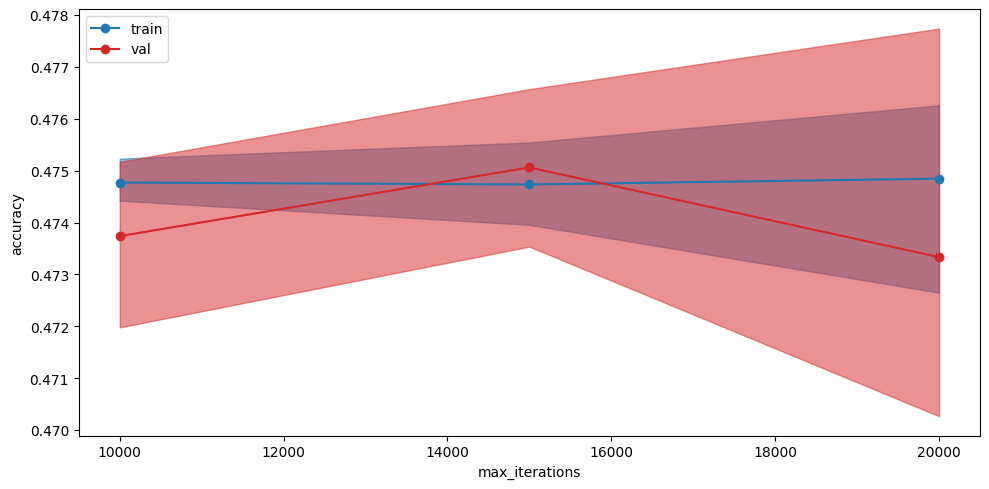

In [ ]:
plt.figure(figsize=(10,5))
x = range(10000, 25000, 5000)
plt.plot(x, [info_accuracy_train_lr[i][0] for i in range(len(x))],'-o', color='tab:blue', label='train')
plt.fill_between(
    x,
    [info_accuracy_train_lr[i][1] for i in range(len(x))],
    [info_accuracy_train_lr[i][2] for i in range(len(x))],
    alpha=0.5,
    color='tab:blue'
)
plt.plot(x, [info_accuracy_val_lr[i][0] for i in range(len(x))],'-o', color='tab:red', label='val')
plt.fill_between(
    x,
    [info_accuracy_val_lr[i][1] for i in range(len(x))],
    [info_accuracy_val_lr[i][2] for i in range(len(x))],
    alpha=0.5,
    color='tab:red'
)
plt.xlabel('max_iterations')
plt.ylabel('accuracy')
plt.legend()
plt.tight_layout()
plt.show()

#### The best value of _'max_iterations'_ seems to be 25000, achieving an accuracy of 41.6%, as confirmed by the hyper-parameter tuning algorithm. Please note that this is a low accuracy score, so this model definitely will not be the best choice.

### Random Forest - hyper-parameter tuning

In [193]:
best_combination_rf = [0,1,2,3]
acc_max_rf = 0
idx = -1
idx_best_rf = idx
info_accuracy_train_rf = []
info_accuracy_val_rf = []

for n_estimators in range(50, 201, 25):
    for max_depth in [5, 10, 15, None]:
        for criterion in ['gini', 'entropy', 'log_loss']:
            for min_samples_leaf in [1, 3, 5]:
                print(f"Starting: {n_estimators} {max_depth} {criterion} {min_samples_leaf}")
                start = time.time()
                idx+=1
                random_states = set()
                while len(random_states) < 5:
                    n = random.randint(0,1000000)
                    random_states.add(n)

                accuracies_train_tmp = []
                accuracies_val_tmp = []

                # iterate over all random states with same training size to derive the 10 different performance
                for random_state in random_states:
                    # further split into training and validation
                    X_train, X_val, y_train, y_val = train_test_split(
                        X_train_val, y_train_val,
                        stratify = y_train_val,
                        train_size = 0.5/0.7,
                        random_state = random_state
                    )

                    rf_clf = RandomForestClassifier(
                        n_estimators=n_estimators,
                        max_depth=max_depth,
                        criterion=criterion,
                        min_samples_leaf=min_samples_leaf,
                        max_features='sqrt',
                        random_state=random_state)

                    rf_clf.fit(X_train, y_train)
                    accuracies_train_tmp.append(accuracy_score(y_train, rf_clf.predict(X_train)))
                    accuracies_val_tmp.append(accuracy_score(y_val, rf_clf.predict(X_val)))

                # calculate the statistics to generate overall performance
                accuracies_tmp = np.array(accuracies_train_tmp)
                mean_acc_train = accuracies_tmp.mean()
                min_acc_train = accuracies_tmp.min()
                max_acc_train = accuracies_tmp.max()
                info_accuracy_train_rf.append((mean_acc_train, min_acc_train, max_acc_train))

                accuracies_tmp = np.array(accuracies_val_tmp)
                mean_acc_val = accuracies_tmp.mean()
                min_acc_val = accuracies_tmp.min()
                max_acc_val = accuracies_tmp.max()
                info_accuracy_val_rf.append((mean_acc_val, min_acc_val, max_acc_val))

                if mean_acc_val >= acc_max_rf:
                        idx_best_rf = idx
                        acc_max_rf = mean_acc_val
                        best_combination_rf[0] = n_estimators
                        best_combination_rf[1] = max_depth
                        best_combination_rf[2] = criterion
                        best_combination_rf[3] = min_samples_leaf

                print(f"Finished: {n_estimators} {max_depth} {criterion} {min_samples_leaf} - {time.time() - start:.2f}s - acc: {mean_acc_train:.4f}/{mean_acc_val:.4f}")

print(
    f'\nBest values: {idx_best_rf} '
    f'n_estimators: {best_combination_rf[0]}, '
    f'max_depth: {best_combination_rf[1]}, '
    f'criterion: {best_combination_rf[2]} '
    f'min_samples_leaf: {best_combination_rf[3]} '
    f'accuracy: {acc_max_rf:.4f}'
)

Starting: 50 5 gini 1
Finished: 50 5 gini 1 - 3.44s - acc: 0.8181/0.8170
Starting: 50 5 gini 3
Finished: 50 5 gini 3 - 3.10s - acc: 0.8111/0.8081
Starting: 50 5 gini 5
Finished: 50 5 gini 5 - 3.12s - acc: 0.8205/0.8183
Starting: 50 5 entropy 1
Finished: 50 5 entropy 1 - 3.64s - acc: 0.7994/0.7970
Starting: 50 5 entropy 3
Finished: 50 5 entropy 3 - 3.69s - acc: 0.8115/0.8062
Starting: 50 5 entropy 5
Finished: 50 5 entropy 5 - 3.74s - acc: 0.8026/0.8021
Starting: 50 5 log_loss 1
Finished: 50 5 log_loss 1 - 3.61s - acc: 0.8023/0.8005
Starting: 50 5 log_loss 3
Finished: 50 5 log_loss 3 - 3.79s - acc: 0.8072/0.8047
Starting: 50 5 log_loss 5
Finished: 50 5 log_loss 5 - 3.68s - acc: 0.8056/0.8021
Starting: 50 10 gini 1
Finished: 50 10 gini 1 - 4.55s - acc: 0.8724/0.8619
Starting: 50 10 gini 3
Finished: 50 10 gini 3 - 4.31s - acc: 0.8711/0.8610
Starting: 50 10 gini 5
Finished: 50 10 gini 5 - 4.28s - acc: 0.8694/0.8598
Starting: 50 10 entropy 1
Finished: 50 10 entropy 1 - 5.39s - acc: 0.8718/0.

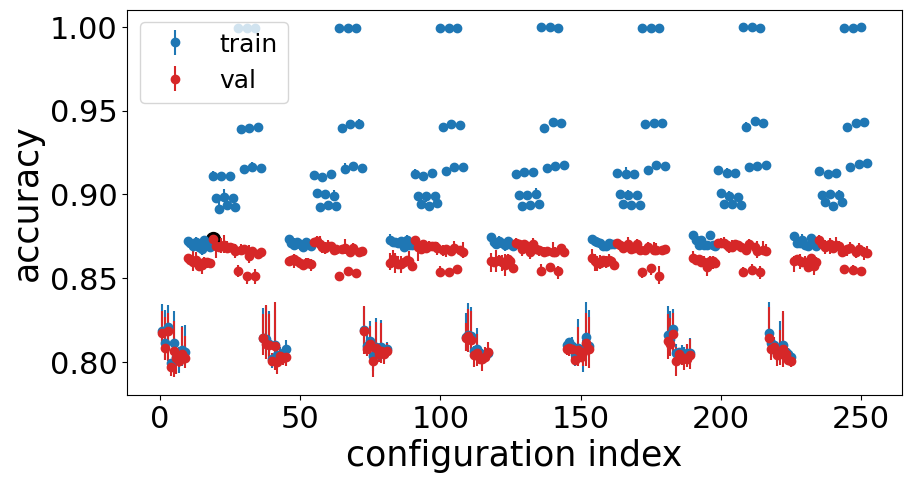

In [196]:
plt.figure(figsize=(10,5))

x = list(range(1, len(info_accuracy_train_rf)+1))
plt.errorbar(x, [info_accuracy_train_rf[i][0] for i in range(len(info_accuracy_train_rf))],
             yerr=([info_accuracy_train_rf[i][0]-info_accuracy_train_rf[i][1] for i in range(len(info_accuracy_train_rf))],[info_accuracy_train_rf[i][2]-info_accuracy_train_rf[i][0] for i in range(len(info_accuracy_train_rf))]),
             marker='o',
             color='tab:blue', label='train',linestyle='')
plt.errorbar(x, [info_accuracy_val_rf[i][0] for i in range(len(info_accuracy_val_rf))],
             yerr=([info_accuracy_val_rf[i][0]-info_accuracy_val_rf[i][1] for i in range(len(info_accuracy_val_rf))],[info_accuracy_val_rf[i][2]-info_accuracy_val_rf[i][0] for i in range(len(info_accuracy_val_rf))]),
             marker='o',
             color='tab:red', label='val',linestyle='')
#plt.title("Grid search results")
plt.xlabel('configuration index', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.legend(fontsize=18)
plt.tick_params(labelsize=22)

plt.scatter(idx_best_rf+1, acc_max_rf, marker='o', color='black',s=100)

plt.show()

### Support Vector Machines (SVM) - hyper-parameter tuning with GridSearchCV().
GridSearchCV() automatically manages the grid search, iterating over all the possible combinations of the values ​​defined in param_grid.

In [156]:
svc_clf = LinearSVC()
svc_clf.fit(X_train_val, y_train_val)
y_train_pred_svc = svc_clf.predict(X_train_val)
y_test_pred_svc = svc_clf.predict(X_test)
print('Training set')
print(classification_report(y_train_val, y_train_pred_svc, zero_division=0))
print('Test set')
print(classification_report(y_test, y_test_pred_svc, zero_division=0))

Training set
              precision    recall  f1-score   support

      benign       0.25      0.88      0.39      3961
    ddos_dns       0.10      0.03      0.05      3758
   ddos_ldap       0.35      0.92      0.50      4149
  ddos_mssql       0.05      0.00      0.01      4138
ddos_netbios       0.98      0.37      0.53      4081
    ddos_ntp       0.56      0.01      0.01       690
   ddos_snmp       0.39      0.86      0.54      4189
   ddos_ssdp       0.83      0.24      0.37      4179
    ddos_syn       0.97      0.40      0.56      3836
   ddos_tftp       0.60      0.78      0.68      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.00      0.00      0.00      4190

    accuracy                           0.40     44967
   macro avg       0.42      0.37      0.30     44967
weighted avg       0.41      0.40      0.32     44967

Test set
              precision    recall  f1-score   support

      benign       0.25      0.90      0.39      1697
  

In [165]:
param_grid = {
    'loss': ['hinge', 'squared_hinge'],
    'tol': [10**-6, 10**-5, 10**-4, 10**-3],
    'C': [0.1, 1, 10, 100],
    'max_iter': [1000, 1500, 2000]
}

grid_search = GridSearchCV(estimator=LinearSVC(), param_grid=param_grid, scoring=make_scorer(accuracy_score), refit=False, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_val, y_train_val)

print('Best values:', grid_search.best_params_)
print(f'Best accuracy: {grid_search.best_score_:.2f}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243

Best values: {'C': 10, 'loss': 'squared_hinge', 'max_iter': 1000, 'tol': 1e-06}
Best accuracy: 0.62


In [166]:
# SVM
svc_clf = LinearSVC(C=10, loss='squared_hinge', max_iter=1000, tol=1e-6)
svc_clf.fit(X_train_val, y_train_val)
y_train_pred_svc = svc_clf.predict(X_train_val)
y_test_pred_svc = svc_clf.predict(X_test)

print("SVM")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_svc))
print('Test set')
print(classification_report(y_test, y_test_pred_svc))

SVM
Training set
              precision    recall  f1-score   support

      benign       0.59      0.79      0.67      3961
    ddos_dns       0.59      0.81      0.68      3758
   ddos_ldap       0.49      0.66      0.56      4149
  ddos_mssql       0.24      0.14      0.18      4138
ddos_netbios       0.50      0.83      0.63      4081
    ddos_ntp       0.62      0.01      0.03       690
   ddos_snmp       0.88      0.87      0.87      4189
   ddos_ssdp       0.67      0.60      0.63      4179
    ddos_syn       0.91      0.97      0.94      3836
   ddos_tftp       0.93      0.72      0.81      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.46      0.49      0.47      4190

    accuracy                           0.61     44967
   macro avg       0.57      0.57      0.54     44967
weighted avg       0.56      0.61      0.57     44967

Test set
              precision    recall  f1-score   support

      benign       0.58      0.80      0.67      169

/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Not good performance at all, so we will no longer consider the SVM model in the next steps.

#### Naive Bayes Classifier

In [189]:
info_accuracy_train_nb = []
info_accuracy_val_nb = []

for var_smoothing in [10**(-i) for i in range(20, -1, -1)]:
    random_states = set()
    while len(random_states) < 5:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuracies_train_tmp = []
    accuracies_val_tmp = []

    # iterate over all random states with same training size to derive the 10 different performance
    for random_state in random_states:
        # further split into training and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val,
            stratify = y_train_val,
            train_size = 0.5/0.7,
            random_state = random_state
        )

    gaussian_clf = GaussianNB(var_smoothing=var_smoothing)
    gaussian_clf.fit(X_train, y_train.ravel())
    accuracies_train_tmp.append(accuracy_score(y_train, gaussian_clf.predict(X_train)))
    accuracies_val_tmp.append(accuracy_score(y_val, gaussian_clf.predict(X_val)))

    # calculate the statistics to generate overall performance
    accuracies_tmp = np.array(accuracies_train_tmp)
    mean_acc = accuracies_tmp.mean()
    min_acc = accuracies_tmp.min()
    max_acc = accuracies_tmp.max()
    info_accuracy_train_nb.append((mean_acc, min_acc, max_acc))

    accuracies_tmp = np.array(accuracies_val_tmp)
    mean_acc = accuracies_tmp.mean()
    min_acc = accuracies_tmp.min()
    max_acc = accuracies_tmp.max()
    info_accuracy_val_nb.append((mean_acc, min_acc, max_acc))
    print(f'var_smoothing={var_smoothing}, avg_acc={mean_acc:.4f}, min-acc={min_acc:.4f}, max-acc={max_acc:.4f}')

var_smoothing=1e-20, avg_acc=0.5742, min-acc=0.5742, max-acc=0.5742
var_smoothing=1e-19, avg_acc=0.5897, min-acc=0.5897, max-acc=0.5897
var_smoothing=1e-18, avg_acc=0.5552, min-acc=0.5552, max-acc=0.5552
var_smoothing=1e-17, avg_acc=0.6333, min-acc=0.6333, max-acc=0.6333
var_smoothing=1e-16, avg_acc=0.5322, min-acc=0.5322, max-acc=0.5322
var_smoothing=1e-15, avg_acc=0.4903, min-acc=0.4903, max-acc=0.4903
var_smoothing=1e-14, avg_acc=0.4134, min-acc=0.4134, max-acc=0.4134
var_smoothing=1e-13, avg_acc=0.4094, min-acc=0.4094, max-acc=0.4094
var_smoothing=1e-12, avg_acc=0.3670, min-acc=0.3670, max-acc=0.3670
var_smoothing=1e-11, avg_acc=0.4024, min-acc=0.4024, max-acc=0.4024
var_smoothing=1e-10, avg_acc=0.3910, min-acc=0.3910, max-acc=0.3910
var_smoothing=1e-09, avg_acc=0.3874, min-acc=0.3874, max-acc=0.3874
var_smoothing=1e-08, avg_acc=0.3297, min-acc=0.3297, max-acc=0.3297
var_smoothing=1e-07, avg_acc=0.2601, min-acc=0.2601, max-acc=0.2601
var_smoothing=1e-06, avg_acc=0.3658, min-acc=0.3

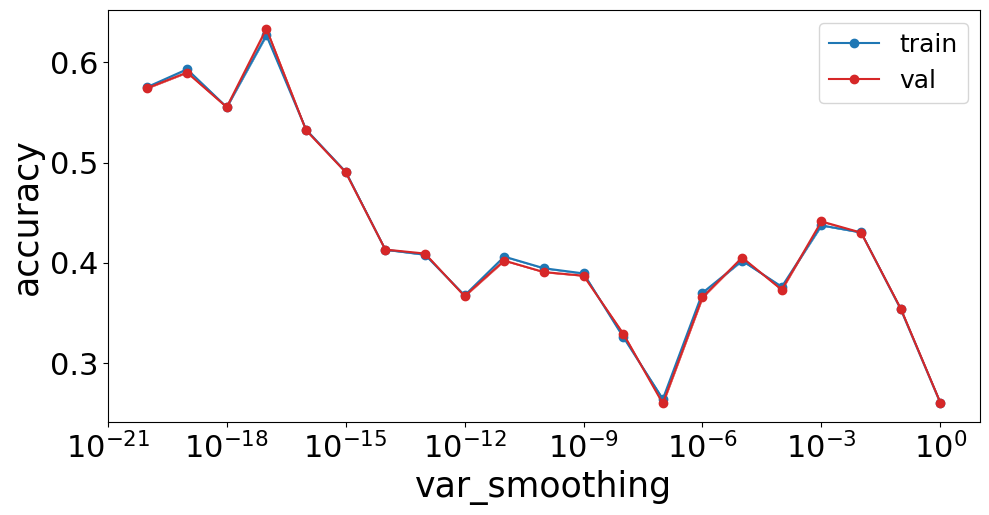

In [219]:
plt.figure(figsize=(10,5.25))
x = [10**(-i) for i in range(20, -1, -1)]
plt.plot(x, [info_accuracy_train_nb[i][0] for i in range(len(x))],'-o', color='tab:blue', label='train')
plt.fill_between(
    x,
    [info_accuracy_train_nb[i][1] for i in range(len(x))],
    [info_accuracy_train_nb[i][2] for i in range(len(x))],
    alpha=0.5,
    color='tab:blue'
)
plt.plot(x, [info_accuracy_val_nb[i][0] for i in range(len(x))],'-o', color='tab:red', label='val')
plt.fill_between(
    x,
    [info_accuracy_val_nb[i][1] for i in range(len(x))],
    [info_accuracy_val_nb[i][2] for i in range(len(x))],
    alpha=0.5,
    color='tab:red'
)
plt.xscale('log')
plt.xlabel('var_smoothing', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.tick_params(labelsize=22)
plt.legend(fontsize=18)
plt.tight_layout()
plt.show()

#### We can assert that the best value for '_var_smoothing_' is 1e-10, achieving an accuracy of 66.9%, as confirmed by the hyper-parameter tuning algorithm.

### Not good performance at all, so we will no longer consider the Naive Bayes model in the next steps.

## Training and testing all the models with the best hyper-parameter values.

#### k-NN

In [170]:
# k-NN
knn_clf = KNeighborsClassifier(n_neighbors=7, weights='distance', p=1, algorithm='ball_tree')
start = time.time()
knn_clf.fit(X_train_val, y_train_val)
fit_end = time.time()
y_train_pred_knn = knn_clf.predict(X_train_val)
y_test_pred_knn = knn_clf.predict(X_test)
predict_end = time.time()
print(f"k-NN fit time: {fit_end-start:.2f}s - Predict time: {predict_end-fit_end:.2f}s")

print("k-NN")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_knn))
print('Test set')
print(classification_report(y_test, y_test_pred_knn))

k-NN fit time: 0.08s - Predict time: 5.02s
k-NN
Training set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      3961
    ddos_dns       1.00      1.00      1.00      3758
   ddos_ldap       1.00      1.00      1.00      4149
  ddos_mssql       1.00      1.00      1.00      4138
ddos_netbios       1.00      1.00      1.00      4081
    ddos_ntp       1.00      1.00      1.00       690
   ddos_snmp       1.00      1.00      1.00      4189
   ddos_ssdp       1.00      1.00      1.00      4179
    ddos_syn       1.00      1.00      1.00      3836
   ddos_tftp       1.00      1.00      1.00      3683
    ddos_udp       1.00      1.00      1.00      4113
ddos_udp_lag       1.00      1.00      1.00      4190

    accuracy                           1.00     44967
   macro avg       1.00      1.00      1.00     44967
weighted avg       1.00      1.00      1.00     44967

Test set
              precision    recall  f1-score   support

      be

#### Logistic Regression

In [171]:
# LR
lr_clf = LogisticRegression(max_iter=15000, solver='saga')
start = time.time()
lr_clf.fit(X_train_val, y_train_val)
fit_end = time.time()
y_train_pred_lr = lr_clf.predict(X_train_val)
y_test_pred_lr = lr_clf.predict(X_test)
predict_end = time.time()
print(f"LR fit time: {fit_end-start:.2f}s - Predict time: {predict_end-fit_end:.2f}")

print("LOGISTIC REGRESSION")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_lr, zero_division=0))     # zero_division=0: labels with no predicted samples set to 0
print('Test set')
print(classification_report(y_test, y_test_pred_lr, zero_division=0))       # zero_division=0: labels with no predicted samples set to 0

LR fit time: 215.63s - Predict time: 0.01
LOGISTIC REGRESSION
Training set
              precision    recall  f1-score   support

      benign       0.26      0.88      0.40      3961
    ddos_dns       0.03      0.01      0.02      3758
   ddos_ldap       0.45      0.67      0.54      4149
  ddos_mssql       0.05      0.00      0.00      4138
ddos_netbios       0.49      0.76      0.60      4081
    ddos_ntp       1.00      0.00      0.01       690
   ddos_snmp       0.95      0.86      0.90      4189
   ddos_ssdp       0.57      0.84      0.68      4179
    ddos_syn       0.97      0.40      0.57      3836
   ddos_tftp       0.60      0.78      0.68      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.38      0.09      0.14      4190

    accuracy                           0.48     44967
   macro avg       0.48      0.44      0.38     44967
weighted avg       0.44      0.48      0.41     44967

Test set
              precision    recall  f1-score   sup

#### Random Forest

In [197]:
# RF
rf_clf = RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_leaf=1, max_features='sqrt', criterion='gini')
start = time.time()
rf_clf.fit(X_train_val, y_train_val)
fit_end = time.time()
y_train_pred_rf = rf_clf.predict(X_train_val)
y_test_pred_rf = rf_clf.predict(X_test)
predict_end = time.time()
print(f"RF fit time: {fit_end-start:.2f}s - Predict time: {predict_end-fit_end:.2f}")
print("RANDOM FOREST")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_rf))
print('Test set')
print(classification_report(y_test, y_test_pred_rf))

RF fit time: 1.54s - Predict time: 0.19
RANDOM FOREST
Training set
              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      3961
    ddos_dns       1.00      0.98      0.99      3758
   ddos_ldap       0.84      0.94      0.89      4149
  ddos_mssql       0.90      0.60      0.72      4138
ddos_netbios       1.00      1.00      1.00      4081
    ddos_ntp       0.98      1.00      0.99       690
   ddos_snmp       1.00      1.00      1.00      4189
   ddos_ssdp       0.80      0.98      0.88      4179
    ddos_syn       0.98      0.99      0.99      3836
   ddos_tftp       0.99      0.98      0.99      3683
    ddos_udp       0.76      0.73      0.75      4113
ddos_udp_lag       0.74      0.77      0.76      4190

    accuracy                           0.91     44967
   macro avg       0.92      0.91      0.91     44967
weighted avg       0.91      0.91      0.90     44967

Test set
              precision    recall  f1-score   support

  

In [173]:
# NB
gb_clf = GaussianNB(var_smoothing=1e-17)
start = time.time()
gb_clf.fit(X_train_val, y_train_val)
fit_end = time.time()
y_train_pred_gb = gb_clf.predict(X_train_val)
y_test_pred_gb = gb_clf.predict(X_test)
predict_end = time.time()
print(f"NB fit time: {fit_end-start:.2f}s - Predict time: {predict_end-fit_end:.2f}")

print("NB")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_gb, zero_division=0))
print('Test set')
print(classification_report(y_test, y_test_pred_gb, zero_division=0))

NB fit time: 0.08s - Predict time: 0.08
NB
Training set
              precision    recall  f1-score   support

      benign       0.99      0.67      0.80      3961
    ddos_dns       0.90      0.80      0.85      3758
   ddos_ldap       0.61      0.72      0.66      4149
  ddos_mssql       0.50      0.00      0.00      4138
ddos_netbios       0.88      0.55      0.68      4081
    ddos_ntp       0.37      0.96      0.53       690
   ddos_snmp       1.00      1.00      1.00      4189
   ddos_ssdp       0.51      0.95      0.66      4179
    ddos_syn       0.52      1.00      0.69      3836
   ddos_tftp       0.99      0.04      0.08      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.41      1.00      0.58      4190

    accuracy                           0.62     44967
   macro avg       0.64      0.64      0.54     44967
weighted avg       0.65      0.62      0.55     44967

Test set
              precision    recall  f1-score   support

      benign 

In [198]:
# SVM
svc_clf = LinearSVC(C=10, loss='squared_hinge', max_iter=1000, tol=1e-6)
start = time.time()
svc_clf.fit(X_train_val, y_train_val)
fit_end = time.time()
y_train_pred_svc = svc_clf.predict(X_train_val)
y_test_pred_svc = svc_clf.predict(X_test)
predict_end = time.time()
print(f"SVM fit time: {fit_end-start:.2f}s - Predict time: {predict_end-fit_end:.2f}")

print("SVM")
# classification report
print('Training set')
print(classification_report(y_train_val, y_train_pred_svc))
print('Test set')
print(classification_report(y_test, y_test_pred_svc))

SVM fit time: 17.55s - Predict time: 0.00
SVM
Training set
              precision    recall  f1-score   support

      benign       0.59      0.79      0.67      3961
    ddos_dns       0.59      0.81      0.68      3758
   ddos_ldap       0.49      0.66      0.56      4149
  ddos_mssql       0.24      0.14      0.18      4138
ddos_netbios       0.50      0.83      0.63      4081
    ddos_ntp       0.62      0.01      0.03       690
   ddos_snmp       0.88      0.87      0.87      4189
   ddos_ssdp       0.67      0.60      0.63      4179
    ddos_syn       0.91      0.97      0.94      3836
   ddos_tftp       0.93      0.72      0.81      3683
    ddos_udp       0.00      0.00      0.00      4113
ddos_udp_lag       0.46      0.49      0.47      4190

    accuracy                           0.61     44967
   macro avg       0.57      0.57      0.54     44967
weighted avg       0.56      0.61      0.57     44967

Test set
              precision    recall  f1-score   support

      beni

/Users/chiara/.venvs/ml4n/lib/python3.12/site-packages/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


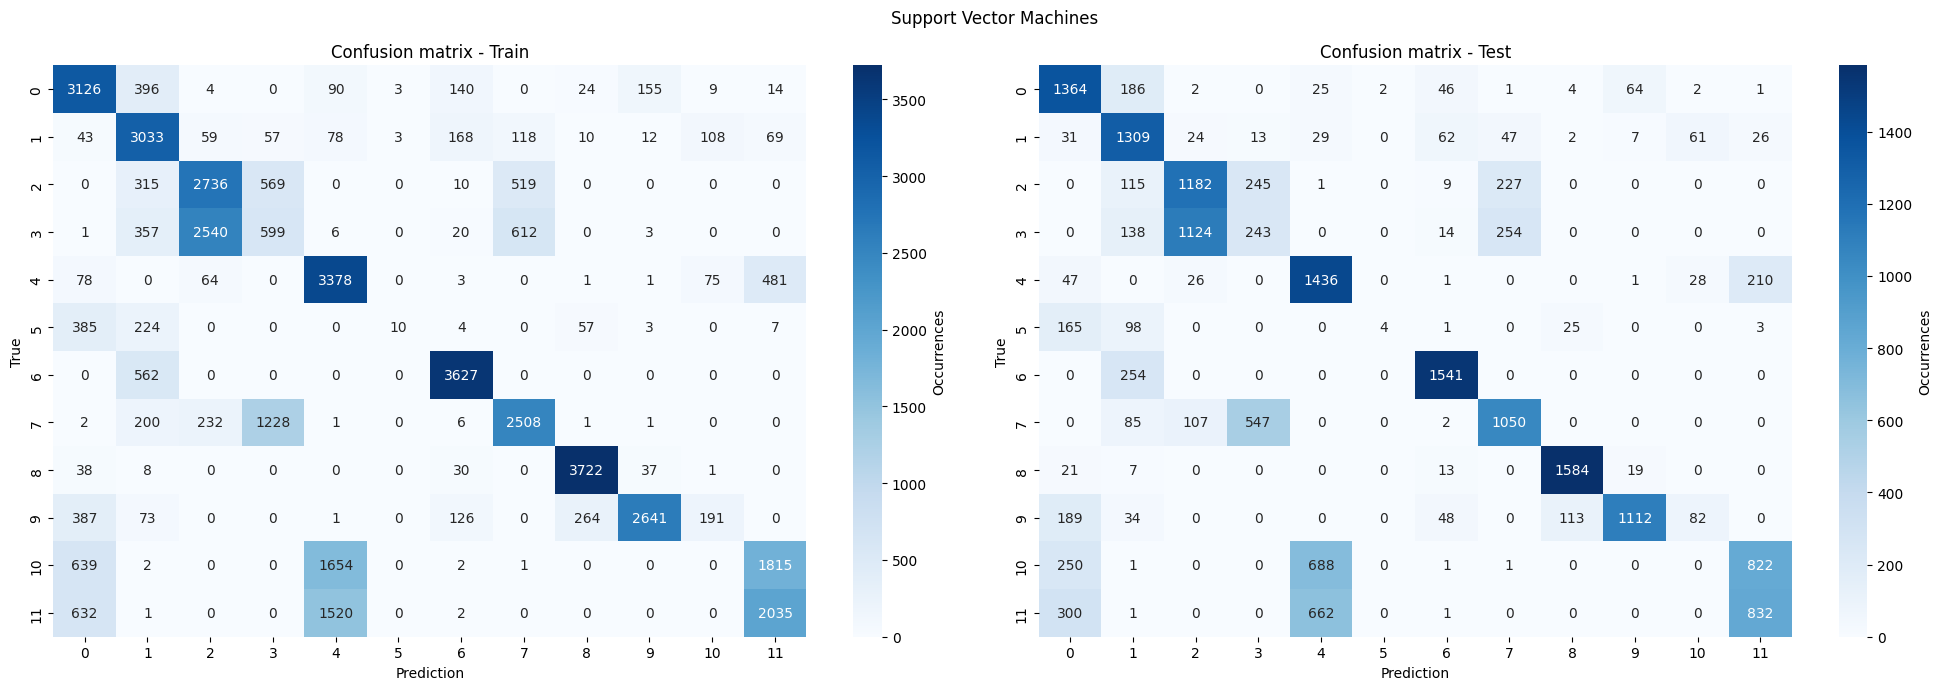

In [199]:
# SVM
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))

confusion_train = confusion_matrix(y_train_val, y_train_pred_svc)
sns.heatmap(confusion_train, cmap='Blues', annot=True, ax=ax1, cbar_kws={'label':'Occurrences'}, fmt='d')
ax1.set_xlabel('Prediction')
ax1.set_ylabel('True')
ax1.set_title('Confusion matrix - Train')

confusion_test = confusion_matrix(y_test, y_test_pred_svc)
sns.heatmap(confusion_test, cmap='Blues', annot=True, ax=ax2, cbar_kws={'label':'Occurrences'}, fmt='d')
ax2.set_xlabel('Prediction')
ax2.set_ylabel('True')
ax2.set_title('Confusion matrix - Test')
fig.suptitle("Support Vector Machines")

plt.tight_layout()
plt.show()

### Learning Curve
Now that we have found the best features and configurations we need to understand what is the optimal number of training samples we should use. To do this we can use the learning curve.
1. First, we select the best model with the best configuration. Then, we define the range of portion of training sample. The goal is to find the proper portion that can generate an accuracy on validation greater than a certain threshold, e.g., 96%, and to see whether it is needed to gather more data.
2. For each of the percentage in the range, we perform a random stratified sampling for k=5 times, and train our model with different portions of training set.

In [201]:
info_accuracy_train_lc = []
info_accuracy_val_lc = []

for train_size in np.arange(0.1, 1.0, 0.1):
    start = time.time()
    # select 5 random states
    random_states = set()
    while len(random_states) < 5:
        n = random.randint(0,1000000)
        random_states.add(n)

    accuracies_train_tmp = []
    accuracies_val_tmp = []

    # iterate over all random states with same training size to derive the 10 different performance
    for random_state in random_states:

        # further split into training and validation
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val, y_train_val,
            stratify = y_train_val,
            train_size = train_size,
            random_state = random_state
        )

        best_model = RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_leaf=1, max_features='sqrt', criterion='gini', random_state=15)
        best_model.fit(X_train, y_train.ravel())
        accuracies_train_tmp.append(accuracy_score(y_train, best_model.predict(X_train)))
        accuracies_val_tmp.append(accuracy_score(y_val, best_model.predict(X_val)))

    # calculate the statistics to generate overall performance
    accuracies_tmp = np.array(accuracies_train_tmp)
    mean_acc_train = accuracies_tmp.mean()
    min_acc_train = accuracies_tmp.min()
    max_acc_train = accuracies_tmp.max()
    info_accuracy_train_lc.append((mean_acc_train, min_acc_train, max_acc_train))

    accuracies_tmp = np.array(accuracies_val_tmp)
    mean_acc_val = accuracies_tmp.mean()
    min_acc_val = accuracies_tmp.min()
    max_acc_val = accuracies_tmp.max()
    info_accuracy_val_lc.append((mean_acc_val, min_acc_val, max_acc_val))

    print(f'{train_size:.2f} - {time.time() - start:.2f} s - {mean_acc_train:.4f}/{mean_acc_val:.4f}')

0.10 - 1.89 s - 0.9563/0.8468
0.20 - 2.31 s - 0.9385/0.8563
0.30 - 2.95 s - 0.9295/0.8616
0.40 - 3.56 s - 0.9236/0.8656
0.50 - 4.25 s - 0.9169/0.8671
0.60 - 4.94 s - 0.9142/0.8680
0.70 - 5.67 s - 0.9120/0.8708
0.80 - 6.49 s - 0.9087/0.8714
0.90 - 7.16 s - 0.9081/0.8718


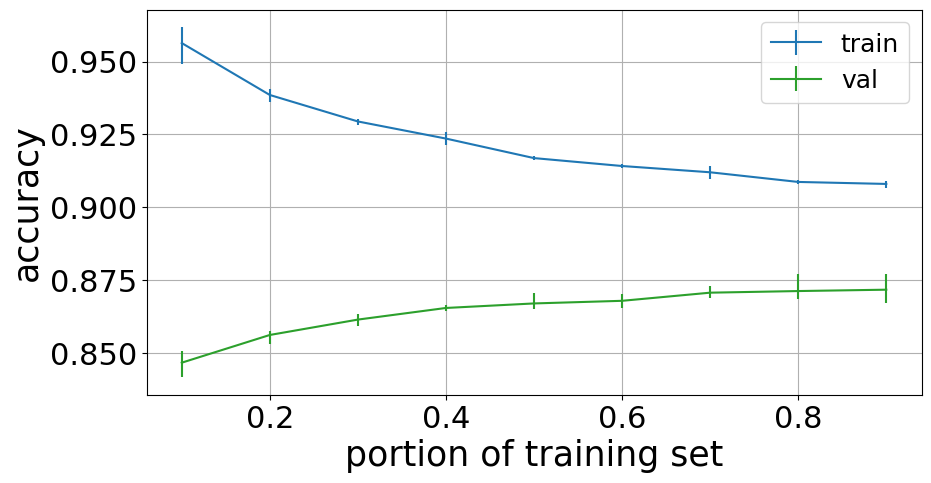

In [207]:
plt.figure(figsize=(10,5))
plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info[0] for info in info_accuracy_train_lc], # y-location of each error bar
    # the size of each error bar
    yerr=[
        [info[0]-info[1] for info in info_accuracy_train_lc],
        [info[2]-info[0] for info in info_accuracy_train_lc]
    ],
    color='tab:blue', label='train'
)
plt.errorbar(
    [train_size for train_size in np.arange(0.1, 1.0, 0.1)], # x-location of each error bar
    [info[0] for info in info_accuracy_val_lc], # y-location of each error bar
    # the size of each error bar
    yerr=[
        [info[0]-info[1] for info in info_accuracy_val_lc],
        [info[2]-info[0] for info in info_accuracy_val_lc]
    ],
    color='tab:green', label='val'
)
plt.grid()
plt.xlabel('portion of training set', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.tick_params(labelsize=22)
#plt.title('Learning curve for Random Forest')
plt.legend(fontsize=18)
plt.show()

#### A portion of 70% is quite effective, as it achieves an accuracy of 86%.

### Testing our best model on test set
Based on the previous analysis, we retrain our final model with all of the aforementioned best selections on all data except test set. In conclusion, we output the final performance in terms of classification report and confusion matrix on the test set.

In [208]:
final_model = RandomForestClassifier(n_estimators=50, max_depth=15, min_samples_leaf=1, max_features='sqrt', criterion='gini', random_state=15)
final_model.fit(X_train_val, y_train_val)
y_pred = final_model.predict(X_test)

In [209]:
# Classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

      benign       1.00      1.00      1.00      1697
    ddos_dns       0.99      0.94      0.97      1611
   ddos_ldap       0.85      0.93      0.88      1779
  ddos_mssql       0.85      0.60      0.70      1773
ddos_netbios       0.99      0.99      0.99      1749
    ddos_ntp       0.86      0.99      0.92       296
   ddos_snmp       1.00      1.00      1.00      1795
   ddos_ssdp       0.79      0.96      0.87      1791
    ddos_syn       0.98      0.98      0.98      1644
   ddos_tftp       0.98      0.98      0.98      1578
    ddos_udp       0.62      0.61      0.61      1763
ddos_udp_lag       0.62      0.63      0.63      1796

    accuracy                           0.87     19272
   macro avg       0.88      0.88      0.88     19272
weighted avg       0.88      0.87      0.87     19272



#### Performance considerations
The final model performs exceptionally well on the test set, achieving perfect accuracy (1.00) across all classes. The classification report shows high precision, recall, and F1-score values for each class, indicating that the model correctly identifies both benign and attack types with no misclassifications. This suggests the model has successfully generalized from the training data to the test set. The results are consistent and reliable, thus confirming the robustness of our final model.


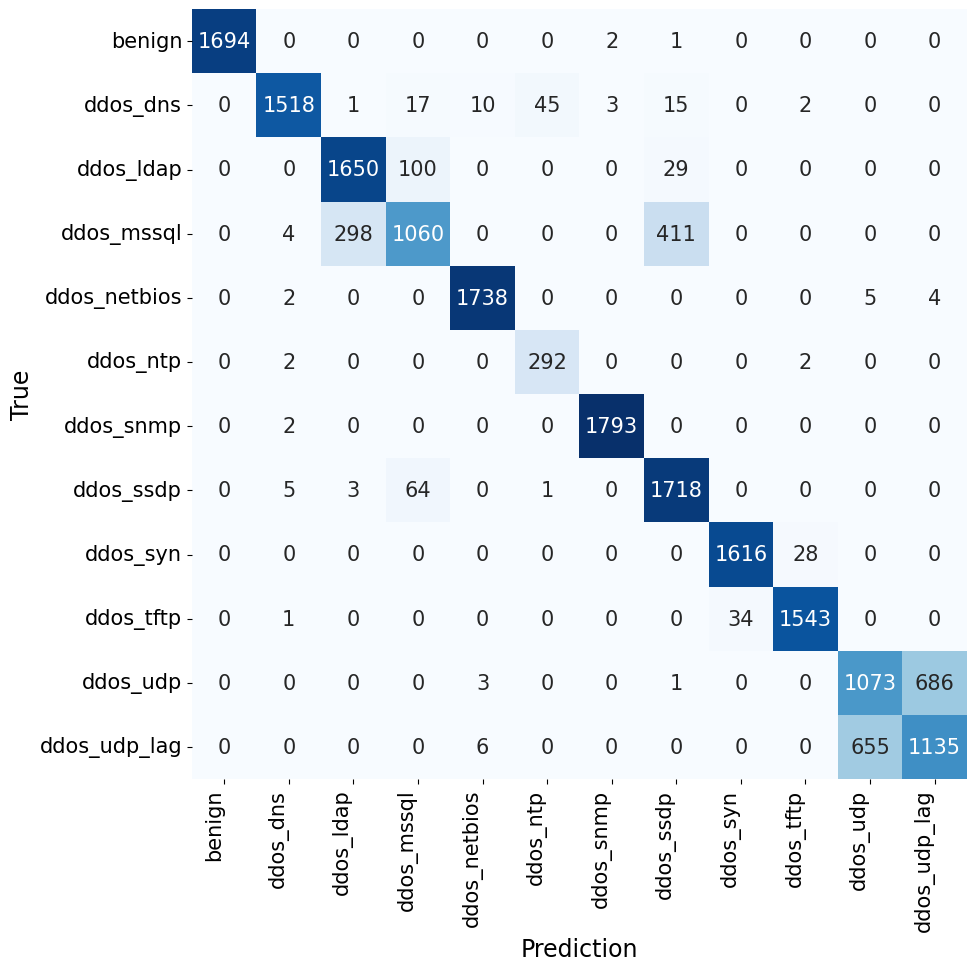

In [210]:
# Confusion matrix of test set
confusion = confusion_matrix(y_test, y_pred)


# Plot the confusion matrix
plt.figure(figsize=(10,10))
fig =  sns.heatmap(confusion, cmap='Blues', annot=True, annot_kws={'size': 15}, cbar=False, fmt='d')
fig.yaxis.set_ticklabels(sorted(np.unique(y_df)), rotation=0, ha='right', fontsize=15)
fig.xaxis.set_ticklabels(sorted(np.unique(y_df)), rotation=90, ha='right', fontsize=15)
plt.xlabel('Prediction', fontsize=17)
plt.ylabel('True', fontsize=17)
#plt.title('Confusion matrix')
plt.show()



### Considerations:
Overall, most classes have a high value of correct predictions along the diagonal, indicating a good level of accuracy.
1. Class 5 shows only 296 correct predictions, because few samples belonging to this class are available in the dataset.
2. There are slight misclassifications between classes 2 and 3 (17 false negatives in class 3).

In [211]:
start_time = time.time()
importances = final_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in final_model.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.011 seconds


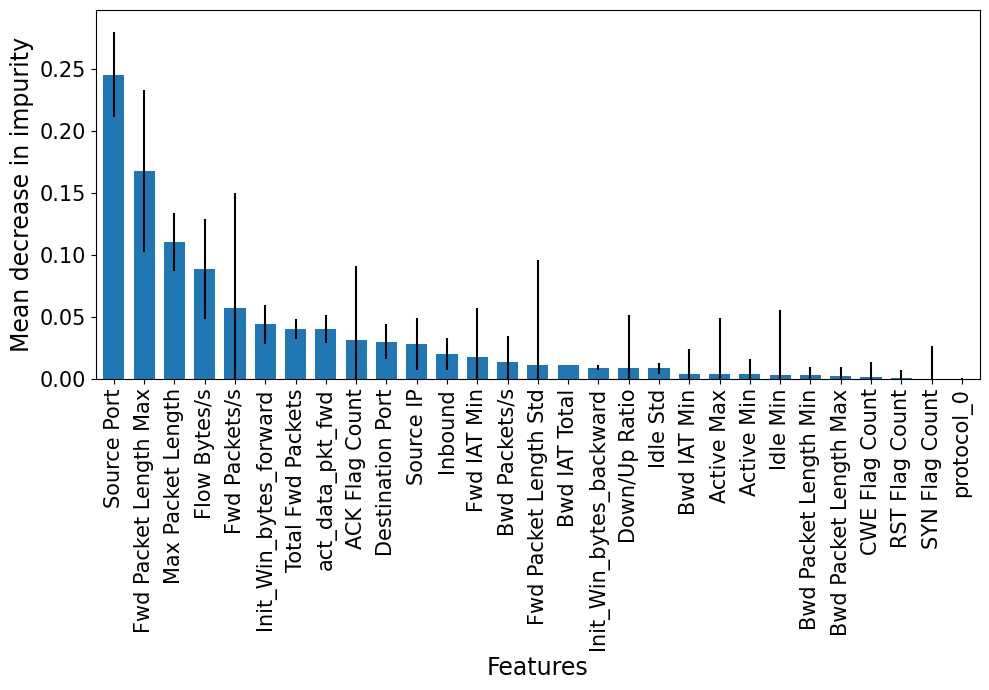

In [216]:
forest_importances = pd.Series(importances, index=df.drop(columns='label').columns)
forest_importances = forest_importances.sort_values(ascending=False)
plt.figure(figsize=(10,7))
forest_importances.plot.bar(yerr=std, width=0.7)
plt.ylabel("Mean decrease in impurity", fontsize=17)
plt.xlabel("Features", fontsize=17)
plt.ylim(bottom=0)
plt.tick_params(labelsize=15)
plt.tight_layout()

#### FP, FN, Recall, and Precision in a DDoS Detection Context
FP: These represent normal traffic erroneously classified as an attack. A high FP rate can lead to false alarms, overwhelming security systems and reducing operational efficiency.

FN: These represent undetected attacks, which are critical as malicious traffic can harm services without being intercepted, thus leading to miss subtle attacks.

Recall: Measures the system’s ability to detect attacks (avoiding FN). Having a high recall is crucial in scenarios where missed attacks represent significant threats.

Precision: Reflects how accurate the system is in detecting attacks (avoiding FP). Achieving a high precision is important to minimize false alarms and maintain realiability in the system.

Real-World Scenarios: Low recall could lead to missing critical attacks, while low precision may generate excessive false alarms, possibly confusing security managers and reducing the effectiveness of the defense system.